In [99]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import unicodedata
import numpy as np

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 

# Gensim imports
import gensim 
from gensim.models import Word2Vec

# Spacy imports
import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)

import contractions

# Plotly imports
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
# Set notebook mode to work in offline
py.init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Image
import cv2
import imutils

# Wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Import data

In [36]:
df = pd.read_csv("data/reviews.csv", header=None)
df.columns = ["date", "text"]
df['date'] = pd.to_datetime(df['date'],unit='s')
df.head()

,date,text
0,2021-01-08 14:49:38,Funny man go shoot
1,2021-01-08 14:49:08,Lots of glitches but at least for me they take...
2,2021-01-08 14:49:59,would only reccomend if they are planning a re...
3,2021-01-08 14:47:00,"Despite all of the negative buzz, I have had a..."
4,2021-01-08 14:42:34,It's a bugged and technically very broken expe...


In [37]:
df.shape

(7096, 2)

# Clean data

In [38]:
STOPWORDS = set(stopwords.words('english')+["game", "really", "would", "one", "much", 
                                            "many", "could", "way", "also", "feel", "like", "think", 'get', 'play', 
                                            'still', 'even', 'say', 'make'])

# Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text)
    stripped_text = soup.get_text()
    return stripped_text

# Removing accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Removing Special Characters
def remove_special_characters(text):
    text = re.sub('[^a-z ]', '', str(text))
    return text

# Lemmatize text
def lemmatize_text(text):
    text = nlp(text) #tokenize
    text = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text]
    return text

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = strip_html_tags(text) # strip html tags
    text = remove_accented_chars(text) # remove accented chars
    text = contractions.fix(text) # expand contractions
    text = nltk.word_tokenize(text) # tokenize 
    text = [remove_special_characters(x) for x in text if remove_special_characters(x)] # remove special characters 
    text = lemmatize_text(" ".join(text)) # lemmatize 
    text = ' '.join(word for word in text if word not in STOPWORDS and len(word) > 2) # remove stopwords and join the tokens
    return text
    
df['text_clean'] = df['text'].apply(clean_text)

In [39]:
df.text[5]

"The core of the game is honestly fun, but the glitches make the experience inconsistent as it constantly breaks your immersion. If you've waited this long already to purchase (1/8/2021), I'd suggest just holding out for a few more months until the kinks get ironed out for the best experience. \r\n\r\nThat being said; I've nearly 100%'d the game and absolutely loved it. Glitches were frustrating sometimes, causing quests to not finish, etc, but the core gameplay mechanics were all fun and enjoyable. Gunplay could use some work, but chaining together quickhacks with melee/stealth kills and occasional headshots from absurd distances are fun and feel rewarding when accomplished without errors. The game is (obviously) heavy on dialogue due to the nature of it being an open-world RPG, but you'll find yourself easily drawn into the stories of the inhabitants of Night City.  Wait for patches and then enjoy what will ultimately be a great cyberpunk experience 6 months from now. Looking forward

In [40]:
df.text_clean[5]

'core honestly fun glitch experience inconsistent constantly break immersion wait long already purchase suggest hold month kink iron good experience nearly absolutely love glitche frustrating sometimes cause quest finish etc core gameplay mechanic fun enjoyable gunplay use work chain together quickhack meleestealth kill occasional headshot absurd distance fun rewarding accomplish without error obviously heavy dialogue due nature openworld rpg find easily draw story inhabitant night city wait patch enjoy ultimately great cyberpunk experience month look forward'

In [41]:
df.to_csv("data/clean_reviews.csv", index=False)

In [42]:
df = pd.read_csv("data/clean_reviews.csv")
df.head()

,date,text,text_clean
0,2021-01-08 14:49:38,Funny man go shoot,funny man shoot
1,2021-01-08 14:49:08,Lots of glitches but at least for me they take...,lot glitch least take nothing away hope add cu...
2,2021-01-08 14:49:59,would only reccomend if they are planning a re...,reccomend plan redux june include cut content ...
3,2021-01-08 14:47:00,"Despite all of the negative buzz, I have had a...",despite negative buzz positive experience litt...
4,2021-01-08 14:42:34,It's a bugged and technically very broken expe...,bugged technically broken experience run gtx s...


# Explore

## Word count distribution

In [43]:
df['word_count'] = df['text_clean'].apply(lambda x: len(str(x).split()))
desc_lengths = list(df['word_count'])
print("Number of descriptions:",len(desc_lengths),
      "\nAverage word count", np.average(desc_lengths),
      "\nMinimum word count", min(desc_lengths),
      "\nMaximum word count", max(desc_lengths))

df['word_count'].iplot(
    kind='hist',
    bins = 50,
    linecolor='black',
    xTitle='word count',
    yTitle='count',
    title='Word Count Distribution')

Number of descriptions: 7096 
Average word count 33.11640360766629 
Minimum word count 1 
Maximum word count 835


In [44]:
# Delete the reviews with 30 words or less
df = df[(df.word_count > 30)].copy()

## Most common words

In [45]:
all_words = df['text_clean'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[0:50],
            y = all_words.values[0:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[0:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [47]:
def load_transparent_image(path):
    """
    The transparency will be loaded as white so it's ready for the wordcloud
    """
    # load image with alpha channel
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)    

    # make mask of where the transparent bits are
    trans_mask = image[:,:,3] == 0

    # replace areas of transparency with white and not transparent
    image[trans_mask] = [255, 255, 255, 255]

    # new image without alpha channel
    new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    
    # resize it
    new_img = imutils.resize(new_img, width=450, height=None, inter=cv2.INTER_AREA)

    return new_img

def print_wordcloud(text, mask, title, size=(12,8)):
    """
    Print a wordcloud with a mask image
    """
    plt.figure(figsize=size)
    wc = WordCloud(background_color="black", max_words=5000, 
                   mask=mask, stopwords=STOPWORDS, max_font_size= 40, random_state=0)
    wc.generate(" ".join(text))
    plt.title(title, fontsize=20)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')

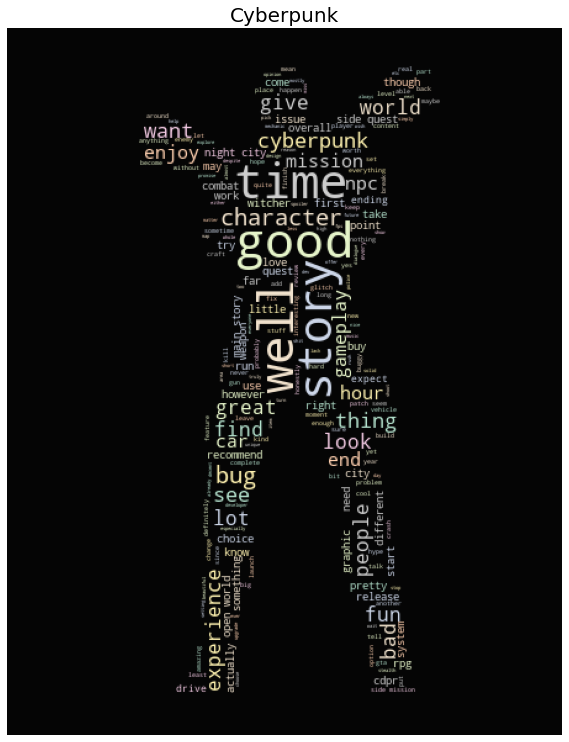

In [50]:
# Wordcloud
image = load_transparent_image("img/cyberpunk-mask.png")

print_wordcloud(df.text_clean.values.tolist(), image, "Cyberpunk", (16,13))

## Bigrams and Trigrams

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n, ngram):
    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_n_bigram(corpus, title, n=20, ngram=2):
    common_words = get_top_n_bigram(corpus, n, ngram)

    df3 = pd.DataFrame(common_words, columns = ['clean' , 'count'])
    df3.groupby('clean').sum()['count'].sort_values(ascending=False).iplot(
        kind='bar', yTitle='Count', linecolor='black', title=f'Top {n} {ngram}-grams: {title}')

In [52]:
plot_n_bigram(df.text_clean, "Reviews", n=25)

In [53]:
plot_n_bigram(df.text_clean, "Reviews", n=25, ngram=3)

# Word2Vec

In [54]:
good_token_clean = []
# list of list of tokens [["this", "is", "one", "sentence"], ["another", "one"],..]
for r in df.text_clean.values.tolist():
    good_token_clean.append(str(r).split())

In [76]:
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
model = Word2Vec(min_count = 3) #cbow
model.build_vocab(good_token_clean)
model.train(good_token_clean, total_examples = model.corpus_count, epochs = 25)

(4160594, 4747175)

In [77]:
# Backup the model
model.save("word2vec.model")

In [79]:
# Load the model from file
model = Word2Vec.load("word2vec.model")

In [133]:
words_to_explore = ["story", "glitch", "bug", "quest", "character", "city", "gameplay", "fun", 
                    "world", "bad", "issue", "performance", "look"]

what_they_say = pd.DataFrame()
for w in words_to_explore:
    predicted = model.predict_output_word([w], topn=10)
    predicted = [c[0] for c in predicted]
    what_they_say[w] = predicted
what_they_say.T

,0,1,2,3,4,5,6,7,8,9
story,main,excellent,compelling,line,amazing,telling,short,fantastic,arc,linear
glitch,graphical,gamebreaking,minor,gamebreake,breaking,encounter,glitch,lucky,visual,funny
bug,graphical,gamebreaking,minor,break,encounter,gamebreake,major,plague,breaking,ark
quest,side,ncpd,main,fetch,marker,secondary,gig,fixer,chain,filler
character,creation,development,customization,voice,personality,meet,connect,create,believable,memorable
city,night,live,district,alive,outskirt,badland,wasteland,huge,architecture,explore
gameplay,core,mehh,enjoyable,gameplay,loop,solid,hour,watch,mechanic,narrative
fun,combat,hacking,super,gunplay,melee,lot,ton,gameplay,shooting,fun
world,open,building,live,detailed,vibrant,dense,immerse,immersive,fill,empty
bad,driving,bad,eargasm,deaf,list,press,glitchy,audience,audio,ending


In [120]:
model.predict_output_word(['story'], topn=10)

[('main', 0.50519806),
 ('excellent', 0.03421433),
 ('compelling', 0.030839624),
 ('line', 0.02635204),
 ('amazing', 0.019248268),
 ('telling', 0.015342619),
 ('short', 0.012731631),
 ('fantastic', 0.0099292295),
 ('arc', 0.0096724965),
 ('linear', 0.009271319)]

In [81]:
model.predict_output_word(['glitch'], topn=10)

[('graphical', 0.72210723),
 ('gamebreaking', 0.038972057),
 ('minor', 0.033700082),
 ('gamebreake', 0.013320996),
 ('breaking', 0.01314418),
 ('encounter', 0.010319149),
 ('glitch', 0.00967622),
 ('lucky', 0.008858773),
 ('visual', 0.008113448),
 ('funny', 0.00808832)]

In [82]:
model.predict_output_word(['mission'], topn=10)

[('side', 0.99162745),
 ('final', 0.0046237647),
 ('ncpd', 0.000655667),
 ('fetch', 0.0002831621),
 ('complete', 0.00023197787),
 ('chain', 0.00018885774),
 ('fixer', 0.00017022585),
 ('main', 0.00011118013),
 ('marker', 0.00010949936),
 ('paste', 8.936826e-05)]

In [83]:
model.predict_output_word(['quest'], topn=10)

[('side', 0.9995283),
 ('ncpd', 0.00011973515),
 ('main', 9.71357e-05),
 ('fetch', 5.101552e-05),
 ('marker', 3.535235e-05),
 ('secondary', 1.5315709e-05),
 ('gig', 1.1808107e-05),
 ('fixer', 1.1240586e-05),
 ('chain', 9.823638e-06),
 ('filler', 6.3435823e-06)]

In [84]:
model.predict_output_word(['character'], topn=10)

[('creation', 0.33357978),
 ('development', 0.11808425),
 ('customization', 0.05994803),
 ('voice', 0.042564854),
 ('personality', 0.041765228),
 ('meet', 0.033133786),
 ('connect', 0.0233858),
 ('create', 0.018812858),
 ('believable', 0.017721424),
 ('memorable', 0.016308568)]

In [85]:
model.predict_output_word(['city'], topn=10)

[('night', 0.99999994),
 ('live', 1.04461e-08),
 ('district', 9.809647e-09),
 ('alive', 5.5733893e-09),
 ('outskirt', 4.4528514e-09),
 ('badland', 3.5489227e-09),
 ('wasteland', 1.8821324e-09),
 ('huge', 1.8084021e-09),
 ('architecture', 1.6822244e-09),
 ('explore', 1.4990835e-09)]

In [86]:
model.predict_output_word(['gameplay'], topn=10)

[('core', 0.11096901),
 ('mehh', 0.037070062),
 ('enjoyable', 0.0350946),
 ('gameplay', 0.034710836),
 ('loop', 0.025445573),
 ('solid', 0.019296242),
 ('hour', 0.018905954),
 ('watch', 0.014738745),
 ('mechanic', 0.014236664),
 ('narrative', 0.011962202)]

In [87]:
model.predict_output_word(['time'], topn=10)

[('spend', 0.75988954),
 ('long', 0.026785966),
 ('waste', 0.022940079),
 ('take', 0.014557334),
 ('slow', 0.0028509202),
 ('load', 0.002603765),
 ('worth', 0.0020663817),
 ('first', 0.0020565735),
 ('sink', 0.0019849928),
 ('put', 0.0019334216)]

In [88]:
model.predict_output_word(['bug'], topn=10)

[('graphical', 0.20071968),
 ('gamebreaking', 0.11896904),
 ('minor', 0.1002312),
 ('break', 0.0468213),
 ('encounter', 0.040398005),
 ('gamebreake', 0.03502629),
 ('major', 0.029834488),
 ('plague', 0.01972167),
 ('breaking', 0.018843006),
 ('ark', 0.012776832)]

In [89]:
model.predict_output_word(['fun'], topn=10)

[('combat', 0.36499366),
 ('hacking', 0.05326944),
 ('super', 0.027182702),
 ('gunplay', 0.027164059),
 ('melee', 0.02676222),
 ('lot', 0.015553213),
 ('ton', 0.011944921),
 ('gameplay', 0.011435628),
 ('shooting', 0.011040469),
 ('fun', 0.010394711)]

In [90]:
model.predict_output_word(['world'], topn=10)

[('open', 0.9999964),
 ('building', 1.5930366e-06),
 ('live', 1.5500635e-07),
 ('detailed', 1.4346575e-07),
 ('vibrant', 1.1964217e-07),
 ('dense', 1.13013265e-07),
 ('immerse', 9.9138035e-08),
 ('immersive', 9.775783e-08),
 ('fill', 7.475389e-08),
 ('empty', 6.766177e-08)]

In [91]:
model.predict_output_word(['bad'], topn=10)

[('driving', 0.30598354),
 ('bad', 0.14881206),
 ('eargasm', 0.045491584),
 ('deaf', 0.043161087),
 ('list', 0.0353267),
 ('press', 0.016260242),
 ('glitchy', 0.013072009),
 ('audience', 0.011796696),
 ('audio', 0.011662388),
 ('ending', 0.010810661)]

In [92]:
model.predict_output_word(['issue'], topn=10)

[('performance', 0.34685674),
 ('major', 0.2706016),
 ('big', 0.14857271),
 ('technical', 0.077452466),
 ('fix', 0.06331345),
 ('solve', 0.035506006),
 ('resolve', 0.0075558233),
 ('gamebreaking', 0.0051228264),
 ('minor', 0.0030097337),
 ('glaring', 0.002804519)]

In [93]:
model.predict_output_word(['recommend'], topn=10)

[('highly', 0.95643365),
 ('anyone', 0.04115212),
 ('current', 0.00038926833),
 ('spec', 0.00032269015),
 ('wholeheartedly', 0.00025940235),
 ('definitely', 0.00016557651),
 ('state', 0.00015614532),
 ('sale', 6.726168e-05),
 ('buck', 4.8708775e-05),
 ('overall', 4.6838617e-05)]

In [95]:
model.predict_output_word(['sale'], topn=10)

[('sale', 0.71205),
 ('wait', 0.261522),
 ('price', 0.010482874),
 ('discount', 0.0016808651),
 ('buy', 0.0013858584),
 ('pick', 0.0013582106),
 ('grab', 0.0009787406),
 ('buck', 0.0009485429),
 ('regret', 0.00072446495),
 ('worth', 0.0006159873)]

In [123]:
model.predict_output_word(['performance'], topn=10)

[('issue', 0.9124076),
 ('optimization', 0.025927234),
 ('performance', 0.015971797),
 ('dlss', 0.00239419),
 ('keanu', 0.0023837034),
 ('gtx', 0.0022998727),
 ('rtx', 0.001835262),
 ('ram', 0.0016648264),
 ('poor', 0.0016568814),
 ('mhz', 0.0009873766)]

In [97]:
model.predict_output_word(['look'], topn=10)

[('forward', 0.9686904),
 ('past', 0.008195078),
 ('gorgeous', 0.002766104),
 ('visually', 0.0024431976),
 ('stunning', 0.0014082987),
 ('clown', 0.0012384865),
 ('amazing', 0.0008943065),
 ('beautiful', 0.00084512547),
 ('looking', 0.00082656916),
 ('great', 0.0005984208)]